In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.colors as mpc
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# #LzL = Slist['LZ_L'][()]
# Satellites.size

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [8]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    zlist = []
    Idlist = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
#             AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
#             templist.extend(list(val))
            zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zz]*tempIds.size)
            
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    
    zorder[is1] = zlist_[is2]
    
    # and remove the ones that today are en the centre
    Loc = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_]
    il = np.where(Loc==-1)
    IndexT_ = IndexT_[il]
    zorder = zorder[il]
    
    
    PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IndexT_]
    
    return PIDs, zorder

In [9]:
# ok, lets test this
# PIDs, zorder = getAllLastP(4338, 4337) # i think i dont need this

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Text(3, 0.3, '$z=0.0$')

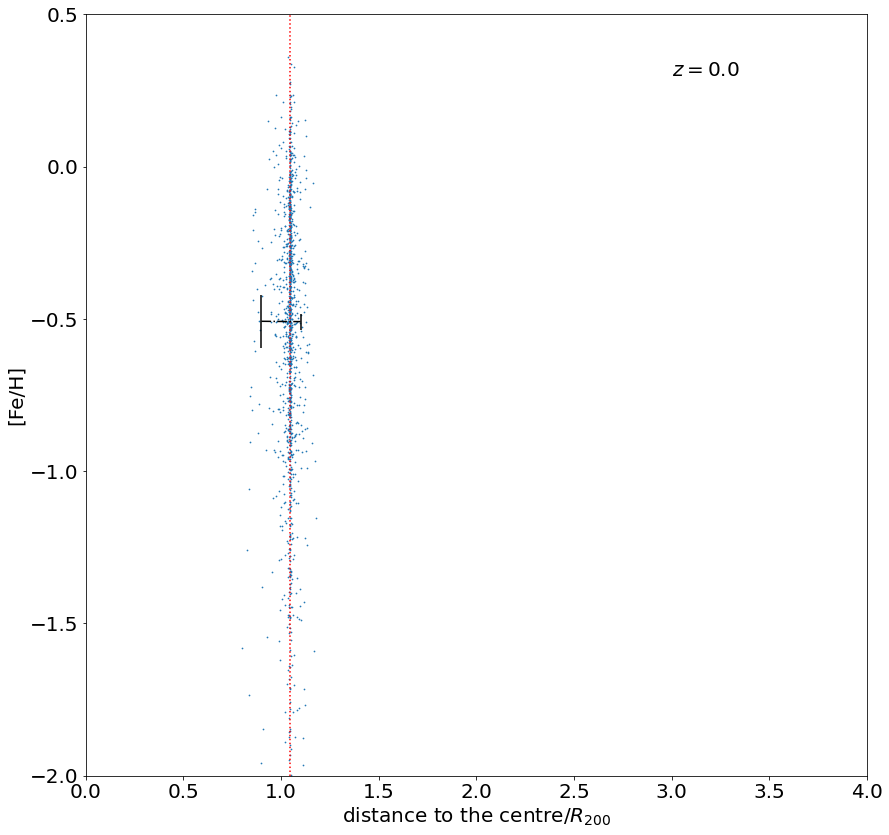

In [13]:
# so, firts, just z = 0, but thinking as any snapshot

uniqueID = int(128*1e6+4338)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4337)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

m, mC = mtree[0], mtreeC[0]

snap, idd = split_unique_id(int(m))
snap, iddC = split_unique_id(int(mC))

# snap = 128

# snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

# IDS_ = np.in1d(snapTotalIDs, PIDs)
# IDS = np.where(IDS_)[0]

zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

# SurvIds_ = snapTotalIDs[IDS]
# iidex = np.in1d(PIDs, SurvIds_)
# iidex_ = np.where(iidex)[0]
# zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
# is1 = np.argsort(SurvIds_) # the target
# is2 = np.argsort(Idlist_)

# zlist = np.zeros(Idlist_.size)
    
# zlist[is1] = zlist_[is2]

IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
pgal = gal-cen

Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
rgal = np.sqrt(np.sum(pgal**2.))/r200

# iz = np.where(zlist>zsnap)

# isin = np.zeros(zlist.size)
# isin[iz] = 1.

# papels = np.array([-0.5, 0.5, 1.5])
# norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun

ii = np.where(np.isinf(Met)==False)

# Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
Met, Rdist = Met[ii], Rdist[ii]

pl.figure(figsize=(14,14))

medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

xss = .5*(xs[1:]+xs[:-1])

pl.scatter(Rdist, Met, marker='o', s=.5)

pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

# bar = pl.colorbar()
# bar.set_ticks((0, 1), ('in', 'out'))
# bar.ax.set_yticklabels(('in', 'out'))

#pl.yscale('log')
# pl.xscale('log')

# pl.xlabel('log(sSFR/yr⁻¹)')
# pl.ylabel('log(Gas Mass ejected/M_sun)')

pl.ylim((-2.,0.5))
pl.xlim((.0, 4.))

pl.xlabel('distance to the centre$/R_{200}$')
pl.ylabel('[Fe/H]')

zsnapT = np.float(np.int(zsnap*1000))/1000
pl.text(3,0.3, '$z={}$'.format(zsnapT))

In [14]:
# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun

    ii = np.where(np.isinf(Met)==False)

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[Fe/H]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('density_4338/R200DistInGal_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
100% (99 of 99) |########################| Elapsed Time: 0:00:16 ETA:  00:00:00

In [12]:
# #ok, for all then
# PIDs, zorder = getAllLastP(4341, 4337)

In [15]:
uniqueID = int(128*1e6+4341)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4337)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun

    ii = np.where(np.isinf(Met)==False)

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[Fe/H]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('density_4341/R200DistInGal_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
  2% (2 of 99) |                         | Elapsed Time: 0:00:00 ETA:   0:00:05/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
100% (99 of 99) |########################| Elapsed Time: 0:00:13 ETA:  00:00:00

In [14]:
# PIDs, zorder = getAllLastP(4470, 4469)

In [16]:
uniqueID = int(128*1e6+4470)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4469)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun

    ii = np.where(np.isinf(Met)==False)

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[Fe/H]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('density_4470/R200DistInGal_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
100% (99 of 99) |########################| Elapsed Time: 0:00:15 ETA:  00:00:00

In [16]:
# PIDs, zorder = getAllLastP(4474, 4469)

In [19]:
uniqueID = int(128*1e6+4474)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4469)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun

    ii = np.where(np.isinf(Met)==False)

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[Fe/H]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('density_4474/R200DistInGal_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
100% (99 of 99) |########################| Elapsed Time: 0:00:14 ETA:  00:00:00

In [9]:
# a few test with O/Fe, just in case

In [11]:
uniqueID = int(128*1e6+4343)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4337)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    #Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun
    Met = np.log10((Abundances[:,3]/OMass)/(Abundances[:,4]/FeMass)) - NoNfe_sun
    
    ii = np.where((np.isinf(Met)==False) & (np.isnan(Met)==False))

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[O/Fe]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('OFe_test/R200DistInGal_4343_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
 17% (17 of 97) |####                    | Elapsed Time: 0:00:02 ETA:   0:00:09/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
100% (97 of 97) |########################| Elapsed Time: 0:00:11 ETA:  00:00:00

In [13]:
uniqueID = int(128*1e6+4476)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4469)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    #Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun
    Met = np.log10((Abundances[:,3]/OMass)/(Abundances[:,4]/FeMass)) - NoNfe_sun
    
#     ii = np.where(np.isinf(Met)==False)
    ii = np.where((np.isinf(Met)==False) & (np.isnan(Met)==False))

    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[O/Fe]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('OFe_test/R200DistInGal_4476_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
 19% (18 of 92) |####                    | Elapsed Time: 0:00:02 ETA:   0:00:08/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
100% (92 of 92) |########################| Elapsed Time: 0:00:10 ETA:  00:00:00

In [14]:
uniqueID = int(128*1e6+4478)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+4469)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

# and now the version for each snapshot
mi = 128-len(mtree)

pbar = progressbar.ProgressBar(max_value=len(mtree))
c = 0

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snap, iddC = split_unique_id(int(mC))

    # snap = 128

    # snapTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][()]

    # IDS_ = np.in1d(snapTotalIDs, PIDs)
    # IDS = np.where(IDS_)[0]

    zsnap = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

    # SurvIds_ = snapTotalIDs[IDS]
    # iidex = np.in1d(PIDs, SurvIds_)
    # iidex_ = np.where(iidex)[0]
    # zlist_, Idlist_ = zorder[iidex_], PIDs[iidex_]
    # is1 = np.argsort(SurvIds_) # the target
    # is2 = np.argsort(Idlist_)

    # zlist = np.zeros(Idlist_.size)

    # zlist[is1] = zlist_[is2]

    IDS = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')

    Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][IDS[0]:IDS[1]]
    Posi = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][IDS[0]:IDS[1]]

    cen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    gal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
    r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]

    X, Y, Z = Posi[:,0]-cen[0],  Posi[:,1]-cen[1],  Posi[:,2]-cen[2]
    pgal = gal-cen

    Rdist = np.sqrt(X**2+Y**2+Z**2)/r200
    rgal = np.sqrt(np.sum(pgal**2.))/r200

    # iz = np.where(zlist>zsnap)

    # isin = np.zeros(zlist.size)
    # isin[iz] = 1.

    # papels = np.array([-0.5, 0.5, 1.5])
    # norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

    #Met = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun
    Met = np.log10((Abundances[:,3]/OMass)/(Abundances[:,4]/FeMass)) - NoNfe_sun
    
#     ii = np.where(np.isinf(Met)==False)
    ii = np.where((np.isinf(Met)==False) & (np.isnan(Met)==False))
    # Met, isin, Rdist = Met[ii], isin[ii], Rdist[ii]
    Met, Rdist = Met[ii], Rdist[ii]

    pl.figure(figsize=(14,14))

    medmet, xs, bins = sp.binned_statistic(Rdist, Met, statistic='median', bins=20, range=(0.,4.))
    mederr, xs, bins = sp.binned_statistic(Rdist, Met, statistic='std', bins=20, range=(0.,4.))
    medcount, xs, bins = sp.binned_statistic(Rdist, Met, statistic='count', bins=20, range=(0.,4.))

    mederr = np.sqrt(np.pi/2.)*mederr/np.sqrt(medcount)

    xss = .5*(xs[1:]+xs[:-1])

    pl.scatter(Rdist, Met, marker='o', s=.5)

    pl.errorbar(xss, medmet, yerr=mederr, ls='-.', color='black', zorder=10)
    pl.plot([rgal, rgal], [-2., 0.5], ls=':', color='red')

    # bar = pl.colorbar()
    # bar.set_ticks((0, 1), ('in', 'out'))
    # bar.ax.set_yticklabels(('in', 'out'))

    #pl.yscale('log')
    # pl.xscale('log')

    # pl.xlabel('log(sSFR/yr⁻¹)')
    # pl.ylabel('log(Gas Mass ejected/M_sun)')

    pl.ylim((-2.,0.5))
    pl.xlim((.0, 4.))

    pl.xlabel('distance to the centre$/R_{200}$')
    pl.ylabel('[O/Fe]')

    zsnapT = np.float(np.int(zsnap*1000))/1000
    pl.text(3,0.3, '$z={}$'.format(zsnapT))

    numb = str(snap-mi).zfill(3)
    pl.savefig('OFe_test/R200DistInGal_4478_{}.png'.format(numb))
    pl.close()
    
    c += 1
    pbar.update(c)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
 10% (10 of 97) |##                      | Elapsed Time: 0:00:01 ETA:   0:00:09/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
100% (97 of 97) |########################| Elapsed Time: 0:00:11 ETA:  00:00:00